In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable
import inflect
import re
from word2number import w2n

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_test = pd.read_csv("Kannada_Test_Set_No_Labels.csv")
kanada_data = pd.concat([kanada_data, kanada_val], axis=0)

tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")
tamil_test = pd.read_csv("Tamil_Test_Set_No_Labels.csv")
tamil_data = pd.concat([tamil_data, tamil_val], axis=0)

tulu_data = pd.read_csv("tulu_train.csv")
tulu_val = pd.read_csv("tulu_val.csv")
tulu_test = pd.read_csv("Tulu_Test_Set_No_Labels.csv")
tulu_data = pd.concat([tulu_data, tulu_val], axis=0)

malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv")
malayalam_test = pd.read_csv("Malayalam_Test_Set_No_Labels.csv")
malayalam_data = pd.concat([malayalam_data, malayalam_val], axis=0)

In [3]:
malayalam_data = malayalam_data[~(~(malayalam_data["Word"].isin([".", "•"])) & (malayalam_data["Tag"] == "SYM"))].replace(".", "asterisk").replace("•", "asterisks").fillna("")

malayalam_mixed = malayalam_data[malayalam_data["Tag"] == "MIXED"]
malayalam_other = malayalam_data[malayalam_data["Tag"] == "OTHER"]
malayalam_number = malayalam_data[malayalam_data["Tag"] == "NUMBER"]
malayalam_eng = malayalam_data[malayalam_data["Tag"] == "ENGLISH"]

tamil_name = tamil_data[tamil_data["Tag"] == "name"]
tamil_name["Tag"] = tamil_name["Tag"].replace("name", "NAME")
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
kanada_name["Tag"] = kanada_name["Tag"].replace("name", "NAME")
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
tulu_name.columns = ["Word", "Tag"]
tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "NAME")
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]

tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
tamil_loc["Tag"] = tamil_loc["Tag"].replace("Location", "PLACE")
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
kanada_loc["Tag"] = kanada_loc["Tag"].replace("location", "PLACE")
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
tulu_loc.columns = ["Word", "Tag"]
tulu_loc["Tag"] = tulu_loc["Tag"].replace("Location", "PLACE")
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]

p = inflect.engine()

def number_to_words(text):
    # Regular expression to find all numbers in the text
    pattern = re.compile(r'(\d+)')
    
    def replace_func(match):
        number = match.group(1)
        number_in_words = p.number_to_words(number)
        return f"_{number_in_words.replace(' ', '_')}_"
    
    return pattern.sub(replace_func, text)





malayalam_data = pd.concat([malayalam_data, malayalam_mixed, kanada_loc, malayalam_eng, malayalam_other, kanada_name, tulu_name, malayalam_number, malayalam_mixed,tamil_name, malayalam_mixed, tulu_loc, malayalam_other, tamil_loc, malayalam_loc, malayalam_mixed, malayalam_name]).fillna("")
malayalam_data["Word"] = malayalam_data["Word"].apply(number_to_words)

C:\Users\justa\AppData\Local\Temp\ipykernel_17520\236453765.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tamil_name["Tag"] = tamil_name["Tag"].replace("name", "NAME")
C:\Users\justa\AppData\Local\Temp\ipykernel_17520\236453765.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kanada_name["Tag"] = kanada_name["Tag"].replace("name", "NAME")
C:\Users\justa\AppData\Local\Temp\ipykernel_17520\236453765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [4]:
malayalam_data.describe()

,Word,Tag
count,49304,49304
unique,12396,8
top,asterisk,MALAYALAM
freq,3079,12408


<Axes: xlabel='Tag', ylabel='Count'>

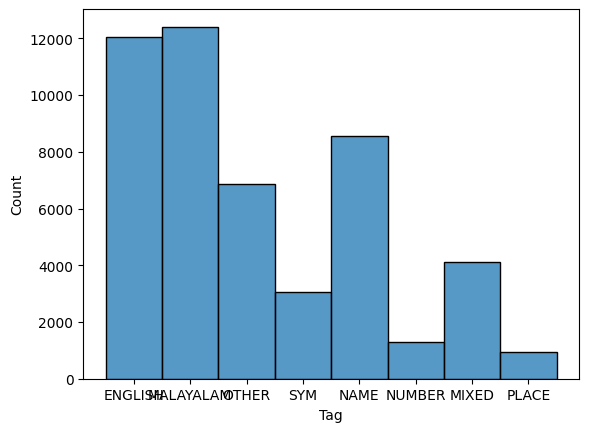

In [5]:
sb.histplot(malayalam_data["Tag"])

In [6]:
malayalam_data[malayalam_data["Tag"] == "NUMBER"]

,Word,Tag
45,_one_hundred_and_thirty-four_,NUMBER
84,_one_hundred_and_ninety_k,NUMBER
86,_one_hundred_and_ninety-five_k,NUMBER
133,_seventeen_k,NUMBER
135,_one_hr,NUMBER
...,...,...
2492,_two_thousand_and_thirteen_,NUMBER
2494,_seventy-five_,NUMBER
2496,_two_thousand_and_sixteen_,NUMBER
2498,_one_hundred_and_fifty_,NUMBER


In [7]:
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')

kf = KFold(n_splits=10, shuffle=True, random_state=42)

model1 = DecisionTreeClassifier(random_state=42)

model2 = LogisticRegression(solver='newton-cg', max_iter=2000)

model3 = svm.SVC()

model7 = VotingClassifier(
    estimators=[
        ('dtc', model1), 
        ('lr', model2), 
        ('svm', model3),
    ],
    voting='hard'
)

acc = [[], [], []] 
f1 = [[], [], []]
pre = [[], [], []]
rec = [[], [], []]

f1_a = [[], [], []]

In [8]:
X = malayalam_data["Word"]
Y = malayalam_data["Tag"]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
    model2.fit(train_vect_count, y_train)
    model2_predict = model2.predict(test_vect_count)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using COUNT VECTORIZATION
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))


In [9]:
DTC = ["Decision Tree Classifier",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
Logistic = ["Logistic Regression", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
SVM = ["Support Vector Machine",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([DTC, Logistic, SVM])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
Decision Tree Classifier,0.9360904416032527,0.9395723374704108,0.9360988967340995,0.9382275780531769,0.9415417831912208
Logistic Regression,0.943919319880065,0.9473658787143349,0.9439233455698206,0.950043700392626,0.9450646970175027
Support Vector Machine,0.9278962831085202,0.9302190432513899,0.927610463770282,0.9398823599006123,0.9221403371609579


In [10]:
x_train = malayalam_data["Word"]
y_train = malayalam_data["Tag"]
x_test = malayalam_val["Word"].replace(".", "asterisk").fillna("").apply(number_to_words)
y_test = malayalam_val["Tag"]

count_vec_train = countVectorizer.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)

model7.fit(count_vec_train, y_train)
model7_predict = model7.predict(count_vec_test)

print(classification_report(y_test, model7_predict), "\n")

              precision    recall  f1-score   support

     ENGLISH       0.97      0.99      0.98       538
   MALAYALAM       1.00      0.99      0.99      1175
       MIXED       0.90      0.98      0.94        63
        NAME       0.96      0.97      0.96       169
      NUMBER       0.97      0.97      0.97        77
       OTHER       0.96      0.91      0.93       179
       PLACE       1.00      1.00      1.00         9
         SYM       1.00      0.99      1.00       294

    accuracy                           0.98      2504
   macro avg       0.97      0.98      0.97      2504
weighted avg       0.98      0.98      0.98      2504
 



In [11]:
x_train = malayalam_data["Word"]
y_train = malayalam_data["Tag"]
final_test = pd.read_csv("Malayalam_Test_Set_No_Labels.csv")
x_test = final_test["Word"].replace(".", "asterisk").fillna("").apply(number_to_words)

count_vec_train = countVectorizer.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)

model7.fit(count_vec_train, y_train)
pred = model7.predict(count_vec_test)

result = pd.concat([final_test.reset_index(drop=True), pd.Series(pred, name="Tag")], axis=1)
result.to_csv('predictions.csv', index=False)

In [12]:
ans = pd.read_csv("predictions.csv")
ans["Tag"].value_counts()

Tag
MALAYALAM    1158
ENGLISH       557
SYM           289
NAME          212
OTHER         162
MIXED          62
NUMBER         50
PLACE          11
Name: count, dtype: int64